In [1]:
# Import necessary functions
import os
import logging
import sys
import time
import numpy as np
import yaml
from pprint import pprint  # For better printing of the config dictionary
from IPython.display import Image, Video, display

%matplotlib ipympl
# For interactive plots in .ipynb scripts

# Directing log messages of level INFO and higher to the console.
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    stream=sys.stdout,  # Explicitly direct logs to standard output
    force=True # Overude jupyter kernel logging settings
)

from experiment_runner import load_config, run_experiment
from utils.plot_utils import animate_trajectory_from_log, plot_reward_per_episode_series

2025-08-07 13:59:29,234 - INFO - Agents package successfully initialized.


2025-08-07 13:59:31,033 - INFO - Loading configuration from: configs/config.yaml
2025-08-07 13:59:31,041 - INFO - Results for this run will be saved in: results/LevelK_MDP_DP_Agent_Stationary_vs_LevelK_TMDP_DP_Agent_Stationary_2025-08-07_13-59-31


Experiment runs:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-07 13:59:31,064 - INFO - Running experiment 1/1 with seed: 42


Initializing value function.:   0%|          | 0/1296 [00:00<?, ?it/s]

Pre-computing lookups for Level-1 TMDP DP Agent (Player DM):   0%|          | 0/1296 [00:00<?, ?it/s]

Initializing value function.:   0%|          | 0/1296 [00:00<?, ?it/s]

Pre-computing lookups for Level-1 MDP DP Agent (Player Adv):   0%|          | 0/1296 [00:00<?, ?it/s]

Epoch for experiment 1:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-08-07 14:00:04,592 - INFO - Plot saved to results/LevelK_MDP_DP_Agent_Stationary_vs_LevelK_TMDP_DP_Agent_Stationary_2025-08-07_13-59-31/LevelK_MDP_DP_Agent_Stationary_vs_LevelK_TMDP_DP_Agent_Stationary_full_rewards.png
2025-08-07 14:00:05,000 - INFO - Plot saved to results/LevelK_MDP_DP_Agent_Stationary_vs_LevelK_TMDP_DP_Agent_Stationary_2025-08-07_13-59-31/LevelK_MDP_DP_Agent_Stationary_vs_LevelK_TMDP_DP_Agent_Stationary_positive_rewards.png
2025-08-07 14:00:05,368 - INFO - Plot saved to results/LevelK_MDP_DP_Agent_Stationary_vs_LevelK_TMDP_DP_Agent_Stationary_2025-08-07_13-59-31/LevelK_MDP_DP_Agent_Stationary_vs_LevelK_TMDP_DP_Agent_Stationary_negative_rewards.png
2025-08-07 14:00:05,748 - INFO - Plot saved to results/LevelK_MDP_DP_Agent_Stationary_vs_LevelK_TMDP_DP_Agent_Stationary_2025-08-07_13-59-31/LevelK_MDP_DP_Agent_Stationary_vs_LevelK_TMDP_DP_Agent_Stationary_only_step_rewards.png
2025-08-07 14:00:06,153 - INFO - Plot saved to results/LevelK_MDP_DP_Agent_Stationary_vs_Le

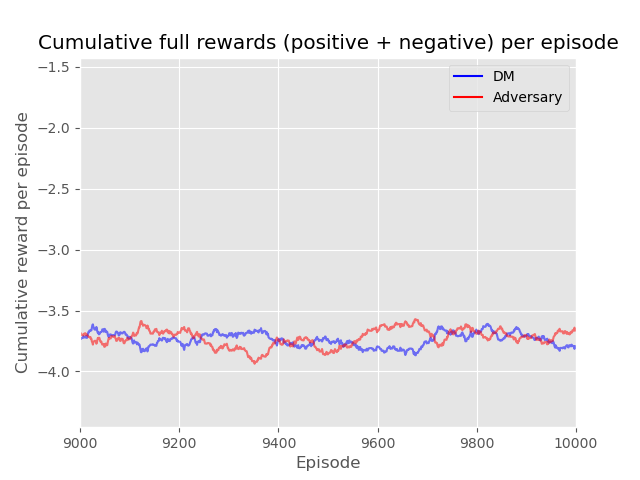

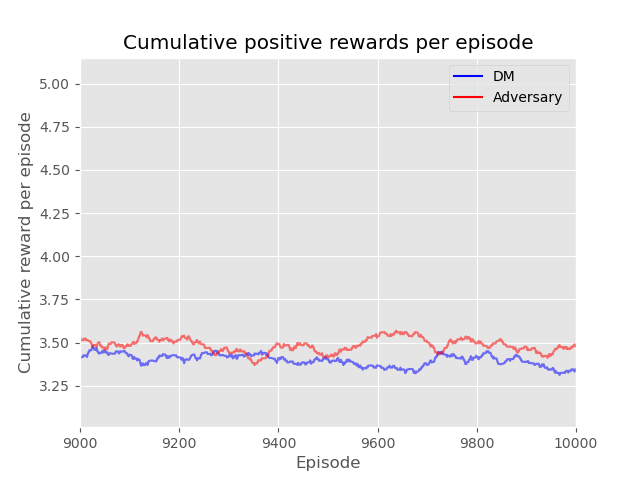

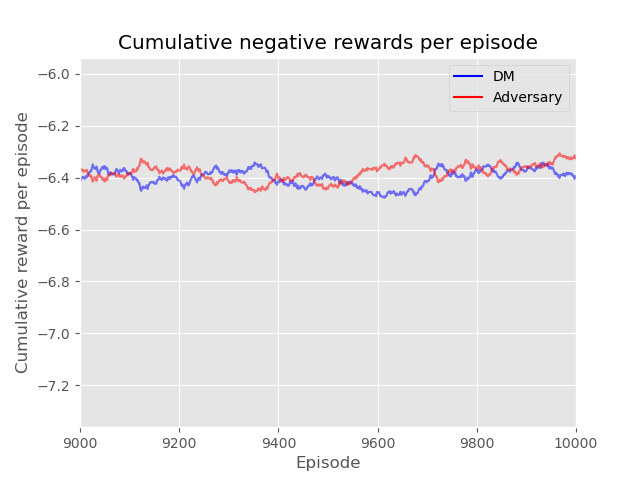

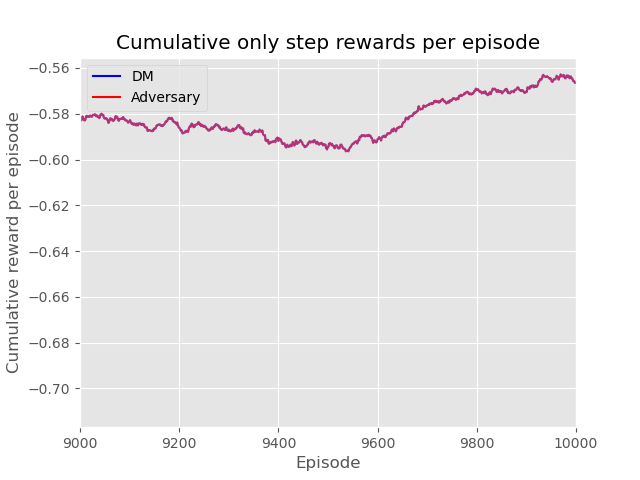

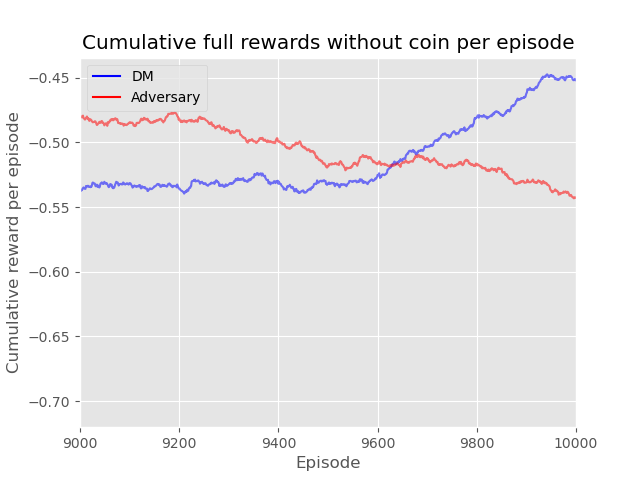

In [2]:
# Load configuration and run the experiment
config_file_path = 'configs/config.yaml'

results_path = run_experiment(config_file_path, log_trajectory=True)

In [3]:
# Specify the Experiment Run to Analyze
# ---------------------------------------------
# TODO: The path can be set to the specific, timestamped experiment folder you want to analyze.

# --- Select moving average window size and range for the player reward plots

plot_moving_average_window_size = 1000
reward_time_series_range = [9000, 10000]


# --- Select which trajectory to animate ---
# The log is structured as: [experiment_run][episode][step]
run_to_animate = 0      # The last experiment run
episode_to_animate = -1  # The last episode of that run

#results_run_directory = results_path

results_run_directory = '/Users/ruzejjur/Github/ARAMARL_TMDP_DP/TMDP_DP/results/LevelK_MDP_DP_Agent_Stationary_vs_LevelK_TMDP_DP_Agent_Stationary_2025-08-07_11-37-13'


In [4]:
# Verify that the directory exists before proceeding
if not os.path.isdir(results_run_directory):
    raise FileNotFoundError(f"The specified directory does not exist: {results_run_directory}")

logging.info(f"Loading results from: {results_run_directory}")
# --- Load Configuration ---
config_path = os.path.join(results_run_directory, 'config.yaml')
try:
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    logging.info("Configuration file 'config.yaml' loaded successfully.")
    # Use pprint for a cleaner print of the configuration dictionary
    logging.info("\n--- Experiment Configuration ---")
    pprint(config)
    logging.info("--------------------------------")
except FileNotFoundError:
    logging.error(f"Configuration file not found at: {config_path}")
    config = None

# --- Load Reward Data ---

# Loading full rewards data
full_rewards_p1_path = os.path.join(results_run_directory, 'full_rewards_per_episode_p1.npy')
full_rewards_p2_path = os.path.join(results_run_directory, 'full_rewards_per_episode_p2.npy')
try:
    # Use np.load to read the saved NumPy array files
    full_rewards_p1 = np.load(full_rewards_p1_path)
    full_rewards_p2 = np.load(full_rewards_p2_path)
    logging.info(f"\n Full reward data loaded successfully. Shape: {full_rewards_p1.shape}")
except FileNotFoundError:
    logging.error("Full reward data (.npy files) not found in the directory.")

    full_rewards_p1, full_rewards_p2 = None, None
    
# Loading positive rewards data
positive_rewards_p1_path = os.path.join(results_run_directory, 'positive_rewards_per_episode_p1.npy')
positive_rewards_p2_path = os.path.join(results_run_directory, 'positive_rewards_per_episode_p2.npy')
try:
    # Use np.load to read the saved NumPy array files
    positive_rewards_p1 = np.load(positive_rewards_p1_path)
    positive_rewards_p2 = np.load(positive_rewards_p2_path)
    logging.info(f"\n Positive reward data loaded successfully. Shape: {positive_rewards_p1.shape}")
except FileNotFoundError:
    logging.error("Positive reward data (.npy files) not found in the directory.")

    positive_rewards_p1, positive_rewards_p2 = None, None
    
# Loading negative rewards data
negative_rewards_p1_path = os.path.join(results_run_directory, 'negative_rewards_per_episode_p1.npy')
negative_rewards_p2_path = os.path.join(results_run_directory, 'negative_rewards_per_episode_p2.npy')
try:
    # Use np.load to read the saved NumPy array files
    negative_rewards_p1 = np.load(negative_rewards_p1_path)
    negative_rewards_p2 = np.load(negative_rewards_p2_path)
    logging.info(f"\n Negative reward data loaded successfully. Shape: {negative_rewards_p1.shape}")
except FileNotFoundError:
    logging.error("Negative reward data (.npy files) not found in the directory.")
    
    negative_rewards_p1, negative_rewards_p2 = None, None
    
# Loading only step rewards data
only_step_rewards_p1_path = os.path.join(results_run_directory, 'only_step_rewards_per_episode_p1.npy')
only_step_rewards_p2_path = os.path.join(results_run_directory, 'only_step_rewards_per_episode_p2.npy')
try:
    # Use np.load to read the saved NumPy array files
    only_step_rewards_p1 = np.load(only_step_rewards_p1_path)
    only_step_rewards_p2 = np.load(only_step_rewards_p2_path)
    logging.info(f"\n Only step reward data loaded successfully. Shape: {only_step_rewards_p1.shape}")
except FileNotFoundError:
    logging.error("Only step reward data (.npy files) not found in the directory.")
    
    only_step_rewards_p1, only_step_rewards_p2 = None, None
    
# Loading full rewards without coin data
full_rewards_without_coin_p1_path = os.path.join(results_run_directory, 'full_rewards_without_coin_per_episode_p1.npy')
full_rewards_without_coin_p2_path = os.path.join(results_run_directory, 'full_rewards_without_coin_per_episode_p2.npy')
try:
    # Use np.load to read the saved NumPy array files
    full_rewards_without_coin_p1 = np.load(full_rewards_without_coin_p1_path)
    full_rewards_without_coin_p2 = np.load(full_rewards_without_coin_p2_path)
    logging.info(f"\n Full reward without coin data loaded successfully. Shape: {full_rewards_without_coin_p1.shape}")
except FileNotFoundError:
    logging.error("Full reward without coin data (.npy files) not found in the directory.")

    full_rewards_without_coin_p1, full_rewards_without_coin_p2 = None, None

    
# --- Load Trajectory Data ---
# This will only exist if log_trajectory=True was used for the run.
trajectory_path = os.path.join(results_run_directory, 'trajectory_log.npy')
try:
    trajectory_logs_all_experiments = np.load(trajectory_path, allow_pickle=True)
    logging.info(f"\n Trajectory log loaded successfully. Contains {len(trajectory_logs_all_experiments)} run(s).")
except FileNotFoundError:
    logging.error("\n Trajectory log ('trajectory_log.npy') not found. Was log_trajectory=True set during the run?")

    trajectory_logs_all_experiments = None

2025-08-07 13:34:19,052 - INFO - Loading results from: /Users/ruzejjur/Github/ARAMARL_TMDP_DP/TMDP_DP/results/LevelK_MDP_DP_Agent_Stationary_vs_LevelK_TMDP_DP_Agent_Stationary_2025-08-07_11-37-13
2025-08-07 13:34:19,059 - INFO - Configuration file 'config.yaml' loaded successfully.
2025-08-07 13:34:19,059 - INFO - 
--- Experiment Configuration ---
{'agent_settings': {'player_1': {'class': 'LevelK_TMDP_DP_Agent_Stationary',
                                 'epsilon_decay_agent': {'end': 0.1,
                                                         'type': 'linear'},
                                 'epsilon_decay_inernal_opponent_model': {'end': 0.1,
                                                                          'type': 'linear'},
                                 'params': {'epsilon': 0.1,
                                            'gamma': 0.9999999999999999,
                                            'initial_V_value': 0,
                                            'k': 1

2025-08-07 13:34:21,942 - INFO - 
--- Creating full reward plot from saved player rewards ---
2025-08-07 13:34:22,011 - INFO - 
--- Creating positive reward plot from saved player rewards ---
2025-08-07 13:34:22,022 - INFO - 
--- Creating negative reward plot from saved player rewards ---
2025-08-07 13:34:22,034 - INFO - 
--- Creating only step reward plot from saved player rewards ---
2025-08-07 13:34:22,047 - INFO - 
--- Creating full reward plot from saved player rewards ---


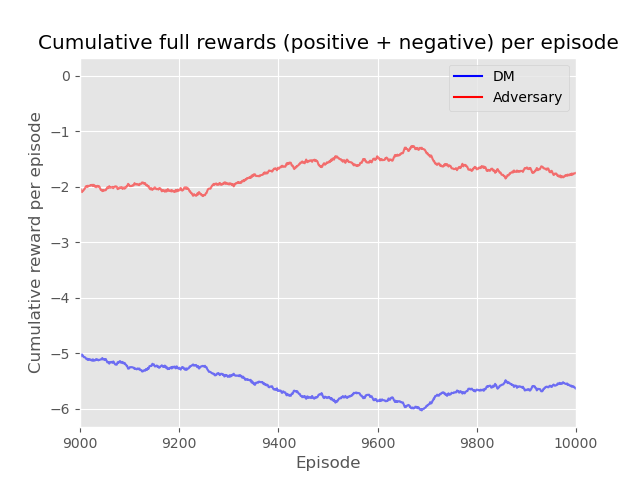

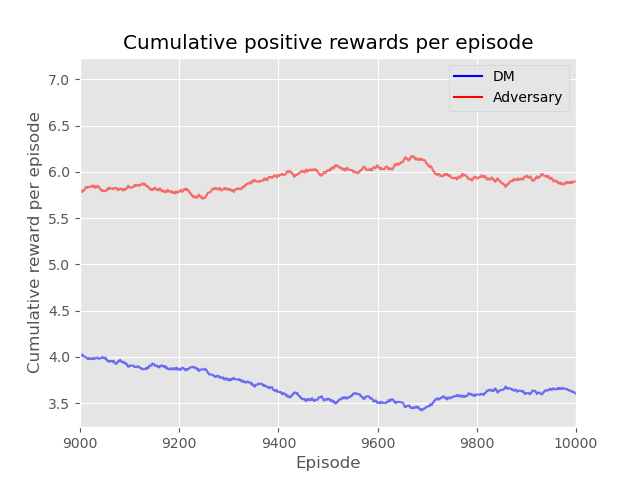

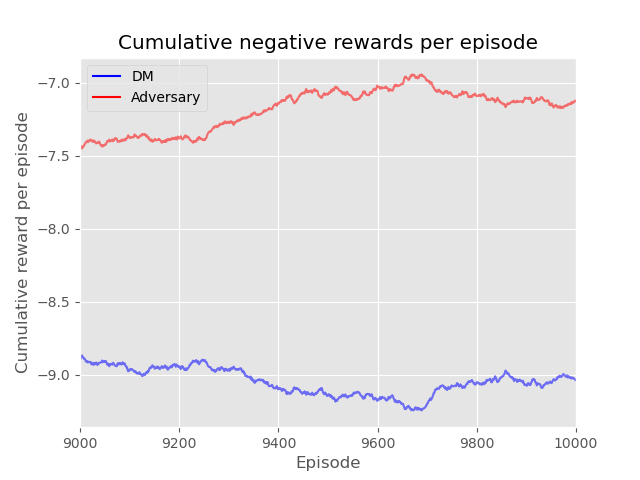

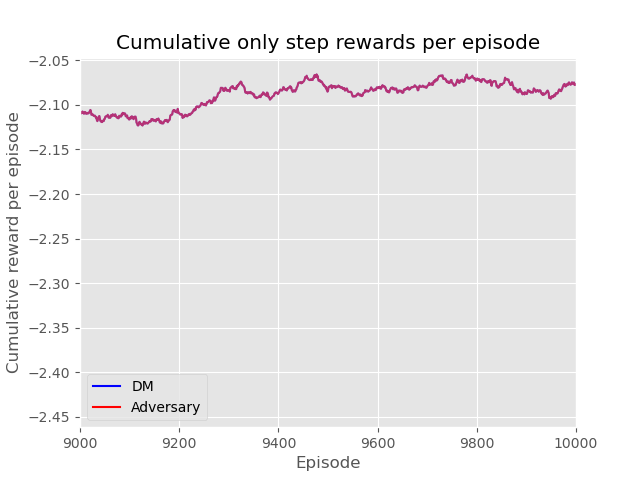

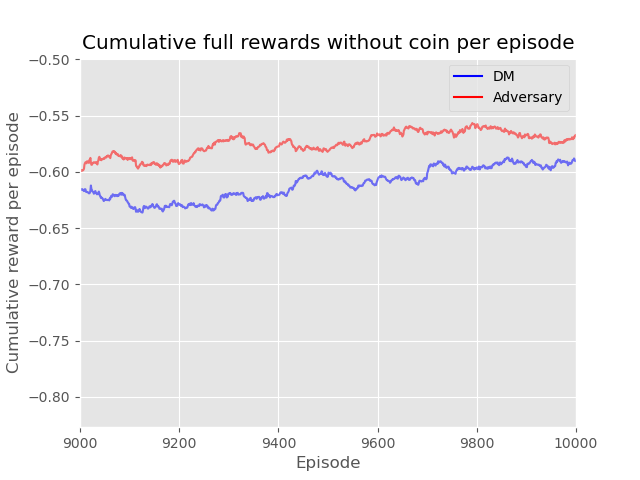

In [5]:
# --- Display the Reward Plot ---
# We can either regenerate the plot from the loaded data or simply display the image that was saved.
# Displaying the image is faster and guarantees we see the original result.

# Plotting full rewards (negative + positive)
if full_rewards_p1 is not None and full_rewards_p2 is not None:
    logging.info("\n--- Creating full reward plot from saved player rewards ---")
    plot_title = 'Cumulative full rewards (positive + negative) per episode'
    
    plot_reward_per_episode_series(full_rewards_p1, full_rewards_p2, plot_title, reward_time_series_range = reward_time_series_range, moving_average_window_size=plot_moving_average_window_size, dir=None)
else:
    logging.info("\nSkipping full rewards plot display as rewards were not not loaded.")

# Plotting only positive rewards
if positive_rewards_p1 is not None and positive_rewards_p2 is not None:
    logging.info("\n--- Creating positive reward plot from saved player rewards ---")
    plot_title = 'Cumulative positive rewards per episode'
    
    plot_reward_per_episode_series(positive_rewards_p1, positive_rewards_p2, plot_title, reward_time_series_range = reward_time_series_range, moving_average_window_size=plot_moving_average_window_size, dir=None)
else:
    logging.info("\nSkipping positive rewards plot display as rewards were not not loaded.")

# Plotting only negative rewards
if negative_rewards_p1 is not None and negative_rewards_p2 is not None:
    logging.info("\n--- Creating negative reward plot from saved player rewards ---")
    plot_title = 'Cumulative negative rewards per episode'
    
    plot_reward_per_episode_series(negative_rewards_p1, negative_rewards_p2, plot_title, reward_time_series_range = reward_time_series_range, moving_average_window_size=plot_moving_average_window_size, dir=None)
else:
    logging.info("\nSkipping negative rewards plot display as rewards were not not loaded.")
    
# Plotting only step rewards
if only_step_rewards_p1 is not None and only_step_rewards_p2 is not None:
    logging.info("\n--- Creating only step reward plot from saved player rewards ---")
    plot_title = 'Cumulative only step rewards per episode'
    
    plot_reward_per_episode_series(only_step_rewards_p1, only_step_rewards_p2, plot_title, reward_time_series_range = reward_time_series_range, moving_average_window_size=plot_moving_average_window_size, dir=None)
else:
    logging.info("\nSkipping only step rewards plot display as rewards were not not loaded.")
    
# Plotting full rewards without coin
if full_rewards_without_coin_p1 is not None and full_rewards_without_coin_p2 is not None:
    logging.info("\n--- Creating full reward plot from saved player rewards ---")
    plot_title = 'Cumulative full rewards without coin per episode'
    
    plot_reward_per_episode_series(full_rewards_without_coin_p1, full_rewards_without_coin_p2, plot_title, reward_time_series_range = reward_time_series_range, moving_average_window_size=plot_moving_average_window_size, dir=None)
else:
    logging.info("\nSkipping full rewards without coin plot display as rewards were not not loaded.")

In [8]:
# --- Animate a Specific Episode from the Trajectory Log ---
if trajectory_logs_all_experiments is not None and config is not None:
    logging.info("\n--- Generating Animation from Trajectory Log ---")
    
    try:
        log_for_one_episode = trajectory_logs_all_experiments[run_to_animate][episode_to_animate]
        
        grid_size = config['environment_settings']['params']['grid_size']
        
        # Generate the animation from this specific episode's log
        animate_trajectory_from_log(log_for_one_episode, grid_size=grid_size, fps=2)
        logging.info("Animation saved as 'trajectory.mp4'")
        
        # Display the generated video in the notebook
        display(Video(url="trajectory.mp4?cache=" + str(time.time()), embed=False))
        
    except (IndexError, TypeError):
        IndexError("Could not extract the specified trajectory log. Check if the run/episode index is valid.")

else:
    logging.info("\nSkipping animation as trajectory data or config was not loaded.")

2025-08-07 12:50:35,246 - INFO - 
--- Generating Animation from Trajectory Log ---
2025-08-07 12:50:35,330 - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-08-07 12:50:35,397 - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x600 -pix_fmt rgba -framerate 2 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y trajectory.mp4
2025-08-07 12:50:36,267 - INFO - Animation saved as 'trajectory.mp4'
